# What's this notebook going to achieve?
I am going to build my first ever simple neural network for classifying handwritten digits with one of the most famous datasets in computer vision, the MNIST. This is a homework of *Chapter 4: Under the Hood: Training a Digit Classifer* of the *Deep Learning for Coders with fastai & Pytorch* book that I have been learning in the past few weeks.

### The outline:
1. The MNIST dataset: how computers knows a digits of number and how the input dataset is structured for Machine Learning problems
   * converting images from .png to tabular data
   * how to tell if all images are equaly sized and comparable?
3. The basics of solving linear models
   * Loss functions
   * Weights, aka coefficients
   * Gradients Descend
   * Accuracy as metrics
   * The 7 steps to find the optimal weights for linear model of your dataset
   * Overfitting: identification and revention
4. Build a simple 3-layered Neural Network with a mix of linear and nonlinear models
   * Activation function
   * 2 label classification: 3 and 7
  
5. Questions to answer
   * What's the final 28x28 weights for classifying 3 and 7 looks like? Make it back to a pixel representation and see if it looks like an actual number or not
   * What is a learner? Is learner a pre-trained model like ResNet26 that can be used for as a foundation for fine-tune my own task and then do inference? Or is learner a Neural Network trained by myself with some training data and can be used for inference directly?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Section 1: The MNIST Handwritten Digits Dataset

Data source: There're many versions of MNIST datasets on Kaggle and online, but I am going to use the sample data provided by the fast.ai library, which can be downloaded using the `untar_data(URL)` function. Let's first see where is the data.

In [2]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

## 1.1 The Structure of the MNIST sample dataset

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

### 1.1.1 First look at labels

In [5]:
labels_df = pd.read_csv('/root/.fastai/data/mnist_sample/labels.csv')

In [6]:
labels_df.label.describe()

count    14434.000000
mean         0.505265
std          0.499990
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [7]:
# randomly select 30 samples from the labels
sample_index = np.random.randint(0, labels_df.shape[0], 10)
labels_df.iloc[sample_index].sort_index(ascending=True)

# summary
# 1. there're 14,434 samples, at least 12,359 are in training set, 12,454 starts to be the validation set. so, 85% is training, 15% is validation set. 
# 2. from the index perspective, the train and validation sets are completely separated from each other
# 3. label are 50% 1 and 50% 0, and the labels mixup in both train and validation set. but I don't know what the label means.

,name,label
1288,train/3/27847.png,0
1503,train/3/35165.png,0
4344,train/3/55947.png,0
8161,train/7/43802.png,1
8533,train/7/36345.png,1
9984,train/7/44538.png,1
10956,train/7/20549.png,1
11539,train/7/26957.png,1
12799,valid/3/7981.png,0
13697,valid/7/911.png,1


### 1.1.2 Then let's look at what's inside train folder
1. Only contains 3 and 7
2. Most importantly: the images are saved as '.png' files, not numbers!

In [8]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [9]:
sevens = (path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/10002.png'),Path('/root/.fastai/data/mnist_sample/train/7/1001.png'),Path('/root/.fastai/data/mnist_sample/train/7/10014.png'),Path('/root/.fastai/data/mnist_sample/train/7/10019.png'),Path('/root/.fastai/data/mnist_sample/train/7/10039.png'),Path('/root/.fastai/data/mnist_sample/train/7/10046.png'),Path('/root/.fastai/data/mnist_sample/train/7/10050.png'),Path('/root/.fastai/data/mnist_sample/train/7/10063.png'),Path('/root/.fastai/data/mnist_sample/train/7/10077.png'),Path('/root/.fastai/data/mnist_sample/train/7/10086.png'),Path('/root/.fastai/data/mnist_sample/train/7/10095.png'),Path('/root/.fastai/data/mnist_sample/train/7/10096.png'),Path('/root/.fastai/data/mnist_sample/train/7/101.png'),Path('/root/.fastai/data/mnist_sample/train/7/10131.png'),Path('/root/.fastai/data/mnist_sample/train/7/1014.png'),Path('/root/.fastai/data/mnist_sample/train/7/10147.png'),Path('/root/.fastai/data/mnist_sample/train/7/10148.png'),Path('/ro

In [10]:
from PIL import Image
seven_rand = np.random.randint(0,len(sevens),10)
Image.open(sevens[seven_rand[0]])

In [11]:
Image.open(sevens[seven_rand[1]])

In [12]:
Image.open(sevens[seven_rand[2]])

In [13]:
Image.open(sevens[seven_rand[-1]])

In [14]:
threes = (path/'train/3').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png'),Path('/root/.fastai/data/mnist_sample/train/3/10093.png'),Path('/root/.fastai/data/mnist_sample/train/3/10097.png'),Path('/root/.fastai/data/mnist_sample/train/3/10099.png'),Path('/root/.fastai/data/mnist_sample/train/3/10116.png'),Path('/root/.fastai/data/mnist_sample/train/3/10125.png'),Path('/root/.fastai/data/mnist_sample/train/3/10137.png'),Path('/root/.fastai/data/mnist_sample/train/3/10141.png'),Path('/ro

In [15]:
from PIL import Image
three_rand = np.random.randint(0,len(threes),4)

In [16]:
Image.open(threes[three_rand[0]])

In [17]:
Image.open(threes[three_rand[1]])

In [18]:
Image.open(threes[three_rand[2]])

In [19]:
Image.open(threes[three_rand[3]])

In [20]:

m7 = sevens[seven_rand[1]]

## 1.2 Converting images from .png into numbers for Numpy/Pytorch manipulation

### 1.2.1 Using one sample 3 to see the pixels

In [21]:
type(threes[three_rand[3]])

pathlib.PosixPath

In [22]:
m3 = Image.open(threes[three_rand[1]]) # type: PngImageFile object
m3t = tensor(m3) # note: m3 has to be image, not the path of the image 
m3t.shape

torch.Size([28, 28])

In [23]:
def print_image_as_pixel(image_tensor, decimal=2):
    tdf = pd.DataFrame(image_tensor)
    styler = tdf.style.format(
        lambda x: f"{x:.{decimal}f}".rstrip('0').rstrip('.') if isinstance(x, float) else x
    )
    return (styler
            .set_properties(**{'font-size':'7pt'})
            .background_gradient(cmap='Greys'))

    # return tdf.format(precision=decimal).style.set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

In [24]:
print_image_as_pixel(m3t)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,46,124,161,255,254,254,254,169,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,37,197,251,253,253,253,253,253,253,253,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,41,230,218,183,114,84,10,10,100,253,236,4,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,25,3,0,0,0,0,0,117,253,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
m3t_df = pd.DataFrame(m3t)
m3t_df.iloc[6:8,2:7]

,2,3,4,5,6
6,0,0,0,46,124
7,0,37,197,251,253


### 1.2.2 Let's see if all the images under Train and Validation as the same size: 28x28

In [28]:
# TODO: find out the different shapes of images using Parallel
from fastcore.parallel import *

train_files = get_image_files(path/'train')
# print(train_files) # don't run this line, it will print out all the files in this folder

def file_size(image): return PILImage.create(image).size

train_file_size = parallel(file_size, train_files, n_workers=10)
pd.Series(train_file_size).value_counts()

(28, 28)    12396
Name: count, dtype: int64

In [29]:
valid_files = get_image_files(path/'valid')
valid_file_size = parallel(file_size,valid_files, n_workers=10)
pd.Series(valid_file_size).value_counts()

(28, 28)    2038
Name: count, dtype: int64

# Section 2: The Basics of Solving Linear Model

## 2.1 Loading the image data into tensors

There're 2 options: 1. build rank-3 tensors; 2. use DataLoader object

In [30]:
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png'),Path('/root/.fastai/data/mnist_sample/train/3/10093.png'),Path('/root/.fastai/data/mnist_sample/train/3/10097.png'),Path('/root/.fastai/data/mnist_sample/train/3/10099.png'),Path('/root/.fastai/data/mnist_sample/train/3/10116.png'),Path('/root/.fastai/data/mnist_sample/train/3/10125.png'),Path('/root/.fastai/data/mnist_sample/train/3/10137.png'),Path('/root/.fastai/data/mnist_sample/train/3/10141.png'),Path('/ro

In [31]:
sevens

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/10002.png'),Path('/root/.fastai/data/mnist_sample/train/7/1001.png'),Path('/root/.fastai/data/mnist_sample/train/7/10014.png'),Path('/root/.fastai/data/mnist_sample/train/7/10019.png'),Path('/root/.fastai/data/mnist_sample/train/7/10039.png'),Path('/root/.fastai/data/mnist_sample/train/7/10046.png'),Path('/root/.fastai/data/mnist_sample/train/7/10050.png'),Path('/root/.fastai/data/mnist_sample/train/7/10063.png'),Path('/root/.fastai/data/mnist_sample/train/7/10077.png'),Path('/root/.fastai/data/mnist_sample/train/7/10086.png'),Path('/root/.fastai/data/mnist_sample/train/7/10095.png'),Path('/root/.fastai/data/mnist_sample/train/7/10096.png'),Path('/root/.fastai/data/mnist_sample/train/7/101.png'),Path('/root/.fastai/data/mnist_sample/train/7/10131.png'),Path('/root/.fastai/data/mnist_sample/train/7/1014.png'),Path('/root/.fastai/data/mnist_sample/train/7/10147.png'),Path('/root/.fastai/data/mnist_sample/train/7/10148.png'),Path('/ro

In [32]:
# use list comprehension to create a nested list which later turns into a rank-3 tensor
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
print(type(seven_tensors))
print(type(three_tensors))

<class 'list'>
<class 'list'>


<Axes: >

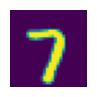

In [33]:
show_image(seven_tensors[195])

<Axes: >

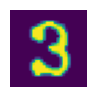

In [34]:
show_image(three_tensors[935])

Use `stack` to turn nested list into a rank-3 tensor. Because the nested list still not easy to iterate and average each images.

In [35]:
stacked_seven = torch.stack(seven_tensors).float()/255
stacked_three = torch.stack(three_tensors).float()/255
print(stacked_seven.shape)
print(stacked_three.shape)

torch.Size([6265, 28, 28])
torch.Size([6131, 28, 28])


<Axes: >

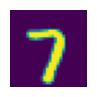

In [36]:
show_image(stacked_seven[195]) # exactly the same as seven_tensors[195], even if we standardized it by 255

In [37]:
print(type(stacked_seven))

<class 'torch.Tensor'>


In [38]:
# rank-3
print(len(stacked_seven.shape))

3


In [39]:
# rank-3 another way to print
stacked_seven.ndim

3

## 2.2 The Baseline: distance from the "average" 3 and 7

In [40]:
mean_seven = stacked_seven.mean(0)

In [41]:
mean_seven.shape

torch.Size([28, 28])

it's interesting that we can print and see what the "average" 7 looks like by just printing it out, note that the "average" 3 and 7 are not exisited in the training set:

In [42]:
print_image_as_pixel(mean_seven, decimal=2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0.01,0.02,0.04,0.05,0.07,0.09,0.1,0.11,0.11,0.11,0.11,0.11,0.1,0.08,0.06,0.04,0.02,0.01,0,0,0,0,0
7,0,0,0,0.01,0.03,0.06,0.1,0.16,0.21,0.27,0.32,0.36,0.39,0.41,0.42,0.43,0.44,0.42,0.38,0.3,0.21,0.12,0.06,0.02,0,0,0,0
8,0,0,0.01,0.03,0.07,0.13,0.21,0.31,0.41,0.51,0.59,0.65,0.69,0.7,0.72,0.73,0.73,0.71,0.65,0.53,0.37,0.22,0.11,0.04,0.01,0,0,0
9,0,0,0.02,0.05,0.1,0.18,0.28,0.4,0.51,0.61,0.68,0.72,0.72,0.7,0.7,0.71,0.74,0.77,0.74,0.62,0.44,0.26,0.12,0.04,0.01,0,0,0


In [43]:
mean_three = stacked_three.mean(0)
print_image_as_pixel(mean_three, decimal=2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.01,0.01,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0.01,0.01,0.03,0.06,0.09,0.14,0.18,0.22,0.25,0.25,0.24,0.2,0.15,0.11,0.06,0.03,0.01,0,0,0,0,0,0
5,0,0,0,0,0.01,0.03,0.06,0.11,0.19,0.28,0.38,0.48,0.56,0.61,0.62,0.6,0.53,0.42,0.31,0.2,0.12,0.05,0.02,0,0,0,0,0
6,0,0,0,0.01,0.02,0.06,0.12,0.21,0.32,0.44,0.54,0.63,0.69,0.72,0.74,0.74,0.71,0.61,0.48,0.34,0.21,0.11,0.04,0.01,0,0,0,0
7,0,0,0,0.01,0.04,0.08,0.15,0.24,0.34,0.43,0.49,0.53,0.54,0.56,0.59,0.63,0.65,0.62,0.53,0.41,0.27,0.14,0.05,0.01,0,0,0,0
8,0,0,0,0.01,0.04,0.08,0.13,0.19,0.25,0.29,0.32,0.32,0.31,0.32,0.37,0.45,0.54,0.57,0.53,0.42,0.28,0.15,0.06,0.01,0,0,0,0
9,0,0,0,0.01,0.03,0.05,0.09,0.12,0.14,0.16,0.16,0.16,0.17,0.21,0.29,0.42,0.53,0.57,0.52,0.39,0.24,0.12,0.04,0.01,0,0,0,0


In [44]:
mean_three.shape

torch.Size([28, 28])

In [45]:
len(mean_three.shape)

2

In [46]:
# to get the average pixel values across all 28x28 pixels in mean_three
mean_three.mean((-1,-2))

tensor(0.1415)

The "average" 3 and 7 are our baseline model!
Now let's use the images from the validation set, label the images as either 3 or 7 by measuring whether this image is closer to the "average" 3 or the "average" 7. To measure distance, we just need to get the delta between each images (28x28 matrics) with the averaged 3's (28x28 matrics), and then sum of squared each values of the 28x28 pixels, and then return a single number

In [47]:
# build stacked valid 3 and 7 tensors
stacked_seven_valid = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]) 
stacked_three_valid = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])

In [48]:
stacked_seven_valid.shape?

Type:            Size
String form:     torch.Size([1028, 28, 28])
Length:          3
File:            /usr/local/lib/python3.11/dist-packages/torch/__init__.py
Docstring:       <no docstring>
Class docstring:
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [49]:
stacked_three_valid.shape?

Type:            Size
String form:     torch.Size([1010, 28, 28])
Length:          3
File:            /usr/local/lib/python3.11/dist-packages/torch/__init__.py
Docstring:       <no docstring>
Class docstring:
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [50]:
def mnist_distance_from_mean(m, image):
    return np.square(m-image).mean((-1,-2))

In [51]:
valid_3_dist = mnist_distance_from_mean(mean_three, stacked_three_valid)
print(valid_3_dist.shape)

torch.Size([1010])


In [52]:
valid_3_dist[:5]

tensor([7835.7461, 7179.0327, 9359.8262, 4797.0337, 5437.8604])

In [53]:
# the above big numbers reminds me of forgetting to standardize the stacked 3 and 7 in validation set
stacked_seven_valid = stacked_seven_valid.float()/255
stacked_three_valid = stacked_three_valid.float()/255

In [54]:
valid_3_dist = mnist_distance_from_mean(mean_three, stacked_three_valid)
print(valid_3_dist.shape)
print(valid_3_dist[:5])

torch.Size([1010])
tensor([0.0520, 0.0856, 0.0883, 0.0353, 0.0476])


In [56]:
print_image_as_pixel(stacked_three_valid[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0.15,0.57,0.74,1,1,1,0.99,0.51,0.2,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0.68,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.71,0.07,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0.51,0.97,0.99,0.95,0.93,0.79,0.99,0.99,0.99,0.99,0.76,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0.12,0.13,0.11,0.11,0.03,0.13,0.38,0.92,0.99,0.9,0.02,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.84,0.99,0.99,0.29,0,0,0,0,0,0,0,0,0


In [61]:
valid_7_dist = mnist_distance_from_mean(mean_seven, stacked_seven_valid)
print(valid_7_dist.ndim)
valid_7_dist[:5]

1


tensor([0.0590, 0.0389, 0.0282, 0.0473, 0.0719])

In [63]:
print_image_as_pixel(stacked_seven_valid[999])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.4,0.73,1,0.46,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0.01,0.24,0.85,0.56,0.75,0.94,1,1,1,0.56,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0.21,1,1,1,1,1,1,1,0.94,0.15,0,0,0,0,0,0,0


In [68]:
valid_7_dist.max(), valid_7_dist.min()

(tensor(0.1109), tensor(0.0213))

In [67]:
valid_3_dist.max(), valid_3_dist.min()

(tensor(0.1173), tensor(0.0328))

🌟🌟🌟 When I implement the baseline myself, when I look at the above distance of 3 and 7 in the validation set with respect to the mean of 3 and 7 from the training set, the epiphany I got was: the distance alone doesn’t mean anything!

Originally I thought the distance would look like a sigmoid that ranges from 0 to 1 and I could use 0.5 threshold as a judge to make predicted labels. Turns out the mean squared of distances of valid_3 with mean_3_train ranges from (tensor(0.0328), tensor(0.1173)), similar for 7. That’s when I realized that the mean squared of distance changes the data so much that I cannot find a single absolute golden standard to make classification judgments, I have to compare the relative differences of distance: aka, get the distance of each image in validation set with respect to both mean_3_train and mean_7_train, and predict the label of the image by comparing the relative distances.

### Using the baseline to make classification prediction and measure accuracy
Make classification based on relative distances and use the accuracy metrics to meausre how good is our baseline is: 
1. concat valid 3 and 7 into one list, preserve the validation image's label in `actual_label`
2. measure the distance of each image with mean_three and mean_seven, saved the distance in 2 lists `dist_three` and `dist_seven`
3. get the `dist_delta = dist_three - dist_seven`, and create the `predicted_label` as if delta >0 then 7 else 3 (delta > 0 means the image is far away from mean_three and closer to mean_seven)
4. create judgement `judge = actual_label == predicted_label`, accuracy metrics is number of True in `judge` divided by the total number of images in validation set.

### step 1: prepare validation set and actual_label

In [71]:
# index 0 to 1009 are 3, 1010 to 2037 are 7
validation_set = torch.cat((stacked_three_valid, stacked_seven_valid), dim=0)

In [73]:
validation_set.shape

torch.Size([2038, 28, 28])

In [74]:
stacked_three_valid.shape, stacked_seven_valid.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [76]:
print_image_as_pixel(validation_set[1009])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0.62,1,1,1,1,1,0.87,0.51,0.36,0.02,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0.1,0.99,0.99,0.99,0.98,0.96,0.99,0.99,0.99,0.99,0.84,0.1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0.04,0.44,0.44,0.44,0.35,0.1,0.44,0.44,0.58,0.95,0.99,0.84,0.56,0.05,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.89,0.99,0.99,0.09,0,0,0,0,0,0,0


In [79]:
print_image_as_pixel(validation_set[1010])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.87,0.58,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0.66,1,1,0.86,0,0,0,0
9,0,0,0,0,0,0,0,0.14,0.55,0.6,0.46,0.58,0.23,0.51,0.53,0.6,0.67,0.68,0.6,0.95,1,1,0.95,0.16,0,0,0,0


In [93]:
# index 0 to 1009 are 3, 1010 to 2037 are 7
actual_label = [3]*stacked_three_valid.shape[0] + [7]*stacked_seven_valid.shape[0]

In [94]:
type(actual_label)

list

In [98]:
len(actual_label)

2038

In [96]:
set(actual_label[0:1009])

{3}

In [97]:
set(actual_label[1010:])

{7}

### step 2: measure distance

In [100]:
dist_three = mnist_distance_from_mean(mean_three, validation_set)
dist_seven = mnist_distance_from_mean(mean_seven, validation_set)

In [101]:
dist_three.shape, dist_seven.shape

(torch.Size([2038]), torch.Size([2038]))

In [102]:
dist_delta = dist_three - dist_seven

In [103]:
dist_delta

tensor([-0.0373,  0.0406, -0.0030,  ...,  0.0377,  0.0331,  0.0355])

In [104]:
predicted_label = np.where(dist_delta>=0, 7,3)

In [106]:
predicted_label

array([3, 7, 3, ..., 7, 7, 7])

### step 3 and 4: accuracy

In [107]:
judge = actual_label == predicted_label

In [112]:
pd.Series(judge).value_counts()
# pd.Series(train_file_size)

True     1969
False      69
Name: count, dtype: int64

In [113]:
accuracy = sum(judge)/validation_set.shape[0]

In [114]:
accuracy

0.9661432777232581

The baseline reaches 96% accuracy!!!

Let's eye-ball some of the 69 samples that are predicted wrong:


In [115]:
wrongly_predicted_image_index = np.where(judge == False)

In [116]:
wrongly_predicted_image_index

(array([   1,   20,   42,   55,   56,   85,  110,  159,  208,  235,  268,
         275,  296,  302,  305,  310,  378,  380,  387,  389,  412,  444,
         450,  452,  458,  486,  491,  568,  586,  611,  661,  701,  708,
         711,  831,  849,  855,  858,  924,  925,  944,  981, 1030, 1034,
        1147, 1150, 1313, 1329, 1377, 1411, 1413, 1423, 1481, 1497, 1502,
        1530, 1582, 1632, 1655, 1680, 1685, 1697, 1715, 1719, 1772, 1890,
        1978, 1980, 2007]),)

In [118]:
len(wrongly_predicted_image_index[0])

69

In [124]:
sum(wrongly_predicted_image_index[0]<=1009) # 42 3-images are predicted as 7

42

In [126]:
sum(wrongly_predicted_image_index[0]>1009) # 27 7-images are predicted as 3

27

This means that the baseline is doing better at predicting 7 than 3. 

In [122]:
# first see the 3 predicted as 7
predicted_label[981]

7

In [119]:
print_image_as_pixel(validation_set[981])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0.08,0.79,0.85,0.07,0.43,0.53,0.74,1,0.45,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0.12,0.55,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.88,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0.5,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.78,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0.29,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.42,0,0,0,0,0,0,0,0,0


In [121]:
# the 7-image predicted as 3
print_image_as_pixel(validation_set[2007])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.65,0.84,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.06,0.78,1,0.94,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0.16,0.62,0.04,0,0,0.2,0.77,1,0.95,0.24,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0.37,1,0.91,0.6,0.6,0.96,1,1,0.39,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0.01,0.53,0.96,1,1,1,1,0.4,0.02,0,0,0,0,0,0,0,0


Don't blame the baseline, looking at the miss-label 3 and 7s in the validation set, it's hard even for human to correctly mark the miss-label 7 image (validation_set[2007]) it just look like a weirly shaped 'f'. 

## 2.3 The Gradient Descent Training Loop

Couple of questions before going down the section:
1. Loss requires the target (y), in classification problem like differentiating 3 and 7, is it a good idea to keep the y as it is? Or shall I encode the 3 and 7 into 0 and 1? What's the difference between these 2 options in terms of (1) final coefficients and predicted label, (2) number of iteration to reach convergence, (3) other math questions such as smoothness of the loss, the size of gradients alone the way
2. When we choose to do Stochastic Gradient Descent, we would need to pick random number of samples, would that mean we only use the randomly picked samples to calculate the loss as well? Would that change the loss function? Where exactly does the sample inclusion happens when calculating loss function?

In [ ]:
# this is my out-of-mind answer on the gradient descent question on Deep ML https://www.deep-ml.com/problems/15
# let's see where I am right or wrong as we move on
def linear_regression_gradient_descent(X, y, alpha, iterations) -> torch.Tensor:
    """
    Solve linear regression via gradient descent using PyTorch autograd.
    X: Tensor or convertible shape (m,n); y: shape (m,) or (m,1).
    alpha: learning rate; iterations: number of steps.
    Returns a 1-D tensor of length n, rounded to 4 decimals.
    """
    X_t = torch.as_tensor(X, dtype=torch.float)
    y_t = torch.as_tensor(y, dtype=torch.float).reshape(-1,1)
    m, n = X_t.shape
    theta = torch.zeros((n,1), requires_grad=True)
    # Your implementation here

    # 1.init weights of size (1,n)
    coeff = np.random.
    coeff.requires_grad()

    for epoch in range(iteration):
    # 2.loss function: mean squared error
        loss = np.mean(np.sqrt(y_t - X_t@coeff))

    # 3. calc gradients
        loss.backwards()
        grad = coeff.gradient()

    # 4. update weights using alpha (learning rate), , and reset gradients to 0
        coeff -= grad*lr
        grad.zero()

    return(coeff)

### First loading the training set
Recall that in the 2.2 baseline we created the `validation_set` to be a (2038, 28, 28) shaped rank-3 tensor, here we represent every image to be a 28x28 matrics. 
In this section, we will be turning the images as a long vector of size (28x28=784, 1). We can do this using the `view` function, which changes the shape of the tensor without changing its content, we will use the special parameter -1 that "makes this axis as bit as necessary to fit all the data".

In [133]:
train_x = torch.cat([stacked_three, stacked_seven]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

Watch Out: The book choose 1 and 0 to represent the target labels, not the original 3 and 7. Why is that?

** guess: it could be related with the magnitude of the `pred = train_x@coeff + bias`, if the coeff and bias are really small then the `pred` would also be small, that is within range of 0 and 1. Then Setting the targets to be within the same range would make sense.
** another guess: if we do `sigmoid(pred)` and then make the delta between y and (0,1) sigmoid results, then it would be better to have a y to be between (0,1)

In [134]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [135]:
# index 0 to 1009 are 3, 1010 to 2037 are 7
valid_x = validation_set.view(-1, 28*28)
valid_x.shape

torch.Size([2038, 784])

In [141]:
valid_y = tensor([1]*stacked_three_valid.shape[0] + [0]*stacked_seven_valid.shape[0]).unsqueeze(1)
valid_y.shape

torch.Size([2038, 1])

### Initailize Coefficience and Bias

Remember to tag the coeff and bias to calculate gradients now.

`torch.randn(n)` generates n random variables from the standard normal distribution. We can use the `*scale` to change the size of the random variable.

In [178]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [142]:
torch.randn(2*2)

tensor([ 0.0154,  0.3519, -0.4411, -0.7006])

In [143]:
# 100 is the scale
torch.randn(2*2)*100

tensor([ -21.5049, -181.4749,  -10.1121,   66.5310])

In [149]:
torch.randn(2*2).shape

torch.Size([4])

In [146]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [144]:
# how many x are there, then we need the same number of coefficients for each one of them
train_x.shape[1]

784

In [192]:
coeff = init_params((train_x.shape[1], 1))
coeff.shape

torch.Size([784, 1])

In [193]:
bias = init_params(1)
bias

tensor([1.1963], requires_grad=True)

### Define a linear layer and non-linear layer

In [151]:
def linear_layer(coeff, bias, train_set):
    return train_set@coeff + bias

In [152]:
# 1st prediction
pred1 = linear_layer(coeff, bias, train_x)

In [153]:
pred1

tensor([[-11.4826],
        [-16.9372],
        [ -9.2035],
        ...,
        [-15.4733],
        [-13.8739],
        [-12.7192]], grad_fn=<AddBackward0>)

In [159]:
torch.sigmoid(tensor(0))

tensor(0.5000)

In [161]:
act_pred1 = torch.sigmoid(pred1)
act_pred1

tensor([[1.0308e-05],
        [4.4084e-08],
        [1.0068e-04],
        ...,
        [1.9057e-07],
        [9.4326e-07],
        [2.9931e-06]], grad_fn=<SigmoidBackward0>)

In [163]:
act_pred1.min(), act_pred1.max()

(tensor(2.6461e-20, grad_fn=<MinBackward1>),
 tensor(1.0000, grad_fn=<MaxBackward1>))

### Define the loss function
Let's combine the linear output and activated by sigmoid function together to calculate the loss function.

Prediction is the confidence of certain images is 3 (label = 1). The higher the prediction, it means the model think it's more likely that this image is a 3; otherwise, more likely to be a 7. 

Loss is ~mean squared error~ mean of ~the confidence of prediction~ the probability of making wrong predictions.

In [181]:
# rule of thumb for loss: the smaller the better, good prediction -> small loss. In another words, loss is the probability of making mistakes.
def mnist_prob_loss(predictions, targets):
    pre = torch.sigmoid(predictions)
    return torch.where(targets==1, 1-pre, pre).mean()

### The training loop

In [195]:
gc.collect()
torch.cuda.empty_cache()

In [183]:
lr = 1e-3

In [184]:
lr

0.001

In [194]:
for i in range(5):
    # ---- training ----
    # zero grads
    if coeff.grad is not None: coeff.grad.zero_()
    if bias.grad  is not None: coeff.grad.zero_()

    pred_train = linear_layer(coeff, bias, train_x)          # uses coeff, bias
    loss_train = mnist_prob_loss(pred_train, train_y)         # scalar tensor
    loss_train.backward()                                     # computes .grad on coeff/bias

    # parameter update (in-place, keeps them as leaf vars requiring grad)
    with torch.no_grad():
        coeff -= lr * coeff.grad
        bias  -= lr * bias.grad

    # ---- validation (no grads) ----
    with torch.no_grad():
        pred_valid = linear_layer(coeff, bias, valid_x)
        loss_valid = mnist_prob_loss(pred_valid, valid_y)
        
    # print scalars, not tensors
    print(f"step={i}; train_loss={loss_train.item():.2f}; valid_loss={loss_valid.item():.2f}")

step=0; train_loss=0.53; valid_loss=0.54
step=1; train_loss=0.53; valid_loss=0.54
step=2; train_loss=0.53; valid_loss=0.54
step=3; train_loss=0.53; valid_loss=0.54
step=4; train_loss=0.53; valid_loss=0.54


Looking at the loss, it barely changed, I think it's because the learning rate is too small.

No, actually I need to comment out the 
```
if coeff.grad is not None: coeff.grad.zero_()
if bias.grad  is not None: bias.grad.zero_()
```
to make it moving.

Why?

In [197]:
lr = 0.1

for i in range(5):
    # ---- training ----
    # zero grads
 for i in range(5):
    # ---- training ----
    # zero grads
    if coeff.grad is not None: coeff.grad.zero_()
    if bias.grad  is not None: bias.grad.zero_()

    pred_train = linear_layer(coeff, bias, train_x)          # uses coeff, bias
    loss_train = mnist_prob_loss(pred_train, train_y)         # scalar tensor
    loss_train.backward()                                     # computes .grad on coeff/bias

    # parameter update (in-place, keeps them as leaf vars requiring grad)
    with torch.no_grad():
        coeff -= lr * coeff.grad
        bias  -= lr * bias.grad

    # ---- validation (no grads) ----
    with torch.no_grad():
        pred_valid = linear_layer(coeff, bias, valid_x)
        loss_valid = mnist_prob_loss(pred_valid, valid_y)

    # print scalars, not tensors
    print(f"step={i}; train_loss={loss_train.item():.2f}; valid_loss={loss_valid.item():.2f}")

    pred_train = linear_layer(coeff, bias, train_x)          # uses coeff, bias
    loss_train = mnist_prob_loss(pred_train, train_y)         # scalar tensor
    loss_train.backward()                                     # computes .grad on coeff/bias

    # parameter update (in-place, keeps them as leaf vars requiring grad)
    with torch.no_grad():
        coeff -= lr * coeff.grad
        bias  -= lr * bias.grad

    # ---- validation (no grads) ----
    with torch.no_grad():
        pred_valid = linear_layer(coeff, bias, valid_x)
        loss_valid = mnist_prob_loss(pred_valid, valid_y)

    # print scalars, not tensors
    print(f"step={i}; train_loss={loss_train.item():.2f}; valid_loss={loss_valid.item():.2f}")

step=0; train_loss=0.52; valid_loss=0.52
step=1; train_loss=0.51; valid_loss=0.52
step=2; train_loss=0.51; valid_loss=0.51
step=3; train_loss=0.50; valid_loss=0.50
step=4; train_loss=0.50; valid_loss=0.49
